# Kaggle : Data Analyst Jobs

### Guillem Martinez Arjona
### 1563566

### Dataset explanation

This dataset contains information about data analyst jobs to help people to find employment.

https://www.kaggle.com/datasets/andrewmvd/data-analyst-jobs 

### Notebook main goal

The main goal of this notebook is to do salary prediction and job classifications.


### Steps
1. Analyze the raw dataset:
    This part is about to see what is the dataset about, what values are inside, check the NaN Values and column types.


2. Clean the dataset:
    Establish a criteria to remove NaN values and useless columns (numerical criteria).
    
    
3. Understand the dataset:
    With the resulting dataset of the first clean, analyze and reason about it.
    
    
4. Dataset processing:
    After understanding the dataset, process it with the required actions
    
    
5. Regressions:
    With all the dataset processed, this part is for the first models
    
    
6. Classifications:
    With all the dataset processed, this part is to try which classification model is the best.
    

7. Future Work

# 1. Dataset Analysis


Global functions used through the notebook

In [1]:
from sklearn.datasets import make_regression
from sklearn import preprocessing
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from IPython.display import display, HTML
import math

def nullCounter(ds):
    print(ds.isnull().sum())
    print("Shape: ", ds.shape)

def printColumnTypes(ds):
    for line in ds.columns:
        print(line, type(ds[line][0]))
    print("-------------------------------------------------------")
    #print(ds)
    print(ds.shape)

Dataset visualization, count of null values inside and shape

In [2]:
# Visualize only 2 decimal numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Function to load the dataset from a csv file
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Dataset loading
ds = load_dataset("data/DataAnalyst.csv")

display(HTML(ds[60:70].to_html()))

nullCounter(ds)

Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         1
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
Easy Apply           0
dtype: int64
Shape:  (2253, 16)


At first sight we can see that the dataset has no NaN values but this is a trap. This dataset has -1 instead of NaNs so what we have to do is check the type of the columns and change the -1 values for NaN. This change will help in the cleaning and later processing.

In [3]:
printColumnTypes(ds)

Unnamed: 0 <class 'numpy.int64'>
Job Title <class 'str'>
Salary Estimate <class 'str'>
Job Description <class 'str'>
Rating <class 'numpy.float64'>
Company Name <class 'str'>
Location <class 'str'>
Headquarters <class 'str'>
Size <class 'str'>
Founded <class 'numpy.int64'>
Type of ownership <class 'str'>
Industry <class 'str'>
Sector <class 'str'>
Revenue <class 'str'>
Competitors <class 'str'>
Easy Apply <class 'str'>
-------------------------------------------------------
(2253, 16)


In [4]:
# Change this -1 to Nan Strings, int and float
ds = ds.replace(-1,np.NaN)
ds = ds.replace("-1",np.NaN)
display(HTML(ds[60:70].to_html()))

After replacing the -1 for NaN let's check how many NaNs do we have

In [5]:
nullCounter(ds)

Unnamed: 0              0
Job Title               0
Salary Estimate         1
Job Description         0
Rating                272
Company Name            1
Location                0
Headquarters          172
Size                  163
Founded               660
Type of ownership     163
Industry              353
Sector                353
Revenue               163
Competitors          1732
Easy Apply           2173
dtype: int64
Shape:  (2253, 16)


As we can see the number of NaN in the majority of attributes is under 20%, except Founded but it is under 30%. We have to focus on two attributes where the amount of NaN values is too big. Those attributes are:
- Competitors: 76.88%
- Easy Apply: 96.45%

This percentage is too high so I have decided to remove those attributes.
In addition to those columns I am going to remove "Unnamed 0" attribute that is completely unnecessary.

# 2. Dataset Clean

In [6]:
#First of all we drop the columns mentioned above
ds = ds.drop(['Unnamed: 0'],axis=1)
ds = ds.drop(['Competitors'],axis=1)
ds = ds.drop(['Easy Apply'],axis=1)

display(HTML(ds[0:10].to_html()))

print(ds.shape)

(2253, 13)


As it is shown, the dataset now has only 13 attributes from the initial 16. Later on you will see how this number of attributes is reduced even more.

I am going to try to remove all the NaN values and depending on the resulting dataset I am going to accept it or find another way to deal with NaN values.

In [7]:
dataset = ds.dropna()
nullCounter(dataset)

Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
dtype: int64
Shape:  (1559, 13)


After dropping all the NaN values I have removed the 30% of the rows. I am going to work with the resulting dataset of 1559 rows and 13 attributes.

# 3. Dataset Understanding

In [8]:
#Attributes
dataset.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue'],
      dtype='object')

A very important thing to do a succesful model is to understand the data that we have. Let's explain the dataset attributes.

- **Job Title:** Name of the job position
- **Salary Estimate:** Earnings range (estimation) of the job according to Glassdoor
- **Job Description:** Explanation of the work that is expected to do in the job
- **Rating:** Number to classify how good is the Company (0-5 scale)
- **Company Name:** Name of the company offering the job
- **Location:** Where the job is done.
- **Headquarters:** Location of the company main offices
- **Size:** Approximate number of employees
- **Founded:** Year when the company was created
- **Type of ownership:** Indicates what is the ownership from
- **Industry:** Generical sector which is the company about.
- **Sector:** Specific topic which is the company about
- **Revenue:** Monetary income range of the company

After understanding the attributes there are some things to do because not all of them are necessary for the predictive model. Some considerations will be made and the resulting actions to fulfill the necessities. Later on actions may be taken to reduce the number of attributes. 

1. Job description is not necessary. This attribute is a massive useless text.
2. Headquarters is somehow duplicated information of Location and it is useless. The important thing is where the job is offered not where the main offices of the company are.
3. Industry and Sector are very similar. One of the two attributes will be deleted.
4. Size, Founded, Type of ownership, and Rating will remain in standby waiting for further analysis

In [9]:
print("Unique Values Industry: ", dataset['Industry'].nunique())
print("Unique Values Sector: ", dataset['Sector'].nunique())

Unique Values Industry:  81
Unique Values Sector:  23


# 4.Dataset processing

In [10]:
#Drop of the columns mentioned above
dataset = dataset.drop(['Job Description'],axis=1)
dataset = dataset.drop(['Headquarters'],axis=1)

After dropping those columns now we have to process each attribute to prepare it for the predictive model. For this predictive model all the attributes should be numerical so there is a lot of work to do because the attributes types are, in majority, strings.

In [11]:
printColumnTypes(dataset)

Job Title <class 'str'>
Salary Estimate <class 'str'>
Rating <class 'numpy.float64'>
Company Name <class 'str'>
Location <class 'str'>
Size <class 'str'>
Founded <class 'numpy.float64'>
Type of ownership <class 'str'>
Industry <class 'str'>
Sector <class 'str'>
Revenue <class 'str'>
-------------------------------------------------------
(1559, 11)


I am going to analyze every attribute to understand it and process it if necessary.

In [12]:
dataset['Job Title'].value_counts()

Data Analyst                          258
Senior Data Analyst                    70
Junior Data Analyst                    30
Business Data Analyst                  19
Data Analyst Junior                    17
                                     ... 
Data Analyst - Marketing Analytics      1
Data Transformation Analyst             1
Jr. Data Analyst                        1
Urgent Need - Data Analyst              1
Senior Quality Data Analyst             1
Name: Job Title, Length: 938, dtype: int64

The first attribute is Job Title, as you can see above there are 938 different values but some of them are very similar. I am going to extract the 25 more frequent values to see what are the predominant values and after that try to extract a conlusion

In [13]:
dataset['Job Title'].value_counts().nlargest(25)

Data Analyst                   258
Senior Data Analyst             70
Junior Data Analyst             30
Business Data Analyst           19
Data Analyst Junior             17
Sr. Data Analyst                14
Data Analyst II                 13
Data Quality Analyst            13
Data Governance Analyst         11
Data Reporting Analyst          11
Lead Data Analyst               10
Sr Data Analyst                  9
Data Analyst III                 8
Data Analyst I                   8
Financial Data Analyst           7
Technical Data Analyst           6
Data Warehouse Analyst           6
Product Data Analyst             5
Marketing Data Analyst           5
Data Management Analyst          5
Research Data Analyst            4
Senior Data Quality Analyst      4
Clinical Data Analyst            4
Data Science Analyst             4
SQL Data Analyst                 4
Name: Job Title, dtype: int64

As we can see Data Analyst is everywhere but after a deep search I have found other interesting job titles as Data Engineer, Data Scientist, Machine Learning, Manager and Director. It is also interesting that many jobs have also like a seniority value like Senior(sr.), Junior, Lead...

My approach will be to try to bring all this job disparity together in different values. Maybe is not the most optimized way but is how I think I will obtain a better result. I am going to divide the job seniority from the job title to process the attribute.

In [14]:
def jobSeniorityProcessor(job):
    if 'sr.' in job.lower() or 'senior' in job.lower() or 'lead' in job.lower() or 'principal' in job.lower():
        return 'SR'
    elif 'jr.' in job.lower() or 'junior' in job.lower():
        return 'JR'
    else:
        return 'OTHER'
    
def jobTitleProcessor(job):
    if 'data scientist' in job.lower() or 'scientist' in job.lower():
        return 'Data Scientist'
    elif 'data engineer' in job.lower():
        return 'Data Engineer'
    elif 'data analyst' in job.lower():
        return 'Data Analyst'
    elif 'machine learning' in job.lower():
        return 'MLE'
    elif 'manager' in job.lower():
        return 'Manager'
    elif 'director' in job.lower():
        return 'Director'
    else:
        return 'Other'

In [15]:
dataset['Job Seniority'] = dataset['Job Title'].apply(jobSeniorityProcessor)
dataset['Job Seniority'].value_counts()

OTHER    1157
SR        341
JR         61
Name: Job Seniority, dtype: int64

<IPython.core.display.Javascript object>


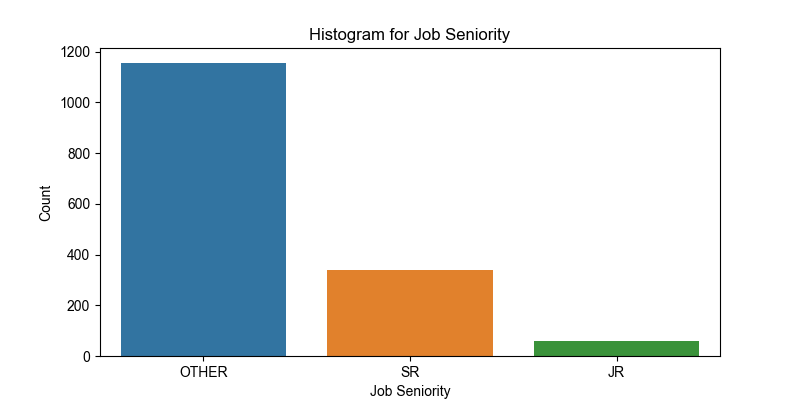

In [16]:
plt.figure(figsize=(8,4))
g = sns.countplot(x='Job Seniority', data=dataset, order = dataset['Job Seniority'].value_counts().index)
p = plt.title('Histogram for Job Seniority')
p = plt.xlabel('Job Seniority')
p = plt.ylabel('Count')

In [17]:
dataset['Job Title'] = dataset['Job Title'].apply(jobTitleProcessor)
dataset['Job Title'].value_counts()
target_names = dataset['Job Title'].unique()

<IPython.core.display.Javascript object>


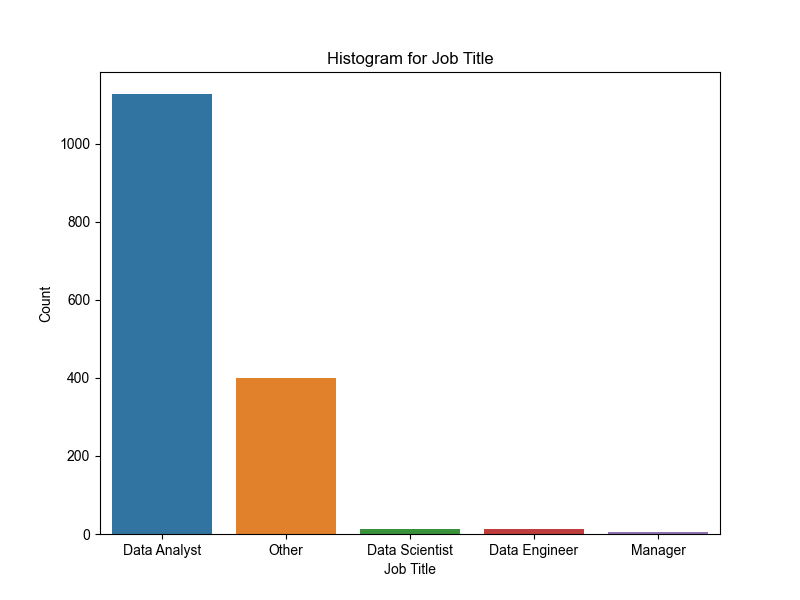

In [18]:
plt.figure(figsize=(8,6))
g = sns.countplot(x='Job Title', data=dataset, order = dataset['Job Title'].value_counts().index)
p = plt.title('Histogram for Job Title')
p = plt.xlabel('Job Title')
p = plt.ylabel('Count')

After processing the Job title attribute now we have reduced the number of unique values with a generalization of the jobs positions. Let's see how the dataset is going so far.

In [19]:
dataset = dataset.reset_index(drop=True)
dataset[0:10]

Job Title             Salary Estimate  Rating  \
0  Data Analyst  $37K-$66K (Glassdoor est.)    3.20   
1  Data Analyst  $37K-$66K (Glassdoor est.)    3.80   
2  Data Analyst  $37K-$66K (Glassdoor est.)    3.40   
3  Data Analyst  $37K-$66K (Glassdoor est.)    4.10   
4  Data Analyst  $37K-$66K (Glassdoor est.)    3.90   
5  Data Analyst  $37K-$66K (Glassdoor est.)    3.90   
6  Data Analyst  $37K-$66K (Glassdoor est.)    4.40   
7         Other  $37K-$66K (Glassdoor est.)    3.70   
8  Data Analyst  $37K-$66K (Glassdoor est.)    4.00   
9  Data Analyst  $37K-$66K (Glassdoor est.)    4.40   

                              Company Name      Location  \
0           Vera Institute of Justice\n3.2  New York, NY   
1  Visiting Nurse Service of New York\n3.8  New York, NY   
2                         Squarespace\n3.4  New York, NY   
3                            Celerity\n4.1  New York, NY   
4                             FanDuel\n3.9  New York, NY   
5                             Point72\n3.9  New York, NY   
6                           Two Sigma\n4.4  New York, NY   
7             GNY Insurance Companies\n3.7  New York, NY   
8                                DMGT\n4.0  New York, NY   
9                           Riskified\n4.4  New York, NY   

                      Size  Founded               Type of ownership  \
0     201 to 500 employees  1961.00          Nonprofit Organization   
1         10000+ employees  1893.00          Nonprofit Organization   
2   1001 to 5000 employees  2003.00               Company - Private   
3     201 to 500 employees  2002.00  Subsidiary or Business Segment   
4    501 to 1000 employees  2009.00               Company - Private   
5   1001 to 5000 employees  2014.00               Company - Private   
6   1001 to 5000 employees  2001.00               Company - Private   
7     201 to 500 employees  1914.00               Company - Private   
8  5001 to 10000 employees  1896.00                Company - Public   
9    501 to 1000 employees  2013.00               Company - Private   

                                Industry                            Sector  \
0                      Social Assistance                        Non-Profit   
1       Health Care Services & Hospitals                       Health Care   
2                               Internet            Information Technology   
3                            IT Services            Information Technology   
4                    Sports & Recreation  Arts, Entertainment & Recreation   
5  Investment Banking & Asset Management                           Finance   
6  Investment Banking & Asset Management                           Finance   
7                     Insurance Carriers                         Insurance   
8       Venture Capital & Private Equity                           Finance   
9                 Research & Development                 Business Services   

                      Revenue Job Seniority  
0  $100 to $500 million (USD)         OTHER  
1      $2 to $5 billion (USD)         OTHER  
2    Unknown / Non-Applicable            SR  
3   $50 to $100 million (USD)         OTHER  
4  $100 to $500 million (USD)         OTHER  
5    Unknown / Non-Applicable         OTHER  
6    Unknown / Non-Applicable         OTHER  
7  $100 to $500 million (USD)         OTHER  
8      $1 to $2 billion (USD)         OTHER  
9    Unknown / Non-Applicable         OTHER

The next attribute to be cleaned is Salary Estimate. As you can see thi attribute has a numerical information but is shown as a string and with a range of values. This string values has to be processed and converted to a number.

In [20]:
dataset['Salary Estimate'].value_counts()

$42K-$76K (Glassdoor est.)     46
$41K-$78K (Glassdoor est.)     42
$50K-$86K (Glassdoor est.)     32
$60K-$66K (Glassdoor est.)     29
$60K-$124K (Glassdoor est.)    26
                               ..
$32K-$56K (Glassdoor est.)      4
$47K-$81K (Glassdoor est.)      2
$36K-$67K (Glassdoor est.)      2
$43K-$77K (Glassdoor est.)      2
$57K-$70K (Glassdoor est.)      1
Name: Salary Estimate, Length: 88, dtype: int64

The Salary Estimate values follow a pattern. I am going to apply a function to process the strings and leave the numbers. As we can see we have 88 unique values.

In [21]:
def salaryProcessor(salary):
    salary = salary.replace(" (Glassdoor est.)", "")
    salary = salary.replace("$","")
    salary = salary.replace("K","")
    return salary

In [22]:
dataset['Salary Estimate'] = dataset['Salary Estimate'].apply(salaryProcessor)
dataset.head()

Job Title Salary Estimate  Rating  \
0  Data Analyst           37-66    3.20   
1  Data Analyst           37-66    3.80   
2  Data Analyst           37-66    3.40   
3  Data Analyst           37-66    4.10   
4  Data Analyst           37-66    3.90   

                              Company Name      Location  \
0           Vera Institute of Justice\n3.2  New York, NY   
1  Visiting Nurse Service of New York\n3.8  New York, NY   
2                         Squarespace\n3.4  New York, NY   
3                            Celerity\n4.1  New York, NY   
4                             FanDuel\n3.9  New York, NY   

                     Size  Founded               Type of ownership  \
0    201 to 500 employees  1961.00          Nonprofit Organization   
1        10000+ employees  1893.00          Nonprofit Organization   
2  1001 to 5000 employees  2003.00               Company - Private   
3    201 to 500 employees  2002.00  Subsidiary or Business Segment   
4   501 to 1000 employees  2009.00               Company - Private   

                           Industry                            Sector  \
0                 Social Assistance                        Non-Profit   
1  Health Care Services & Hospitals                       Health Care   
2                          Internet            Information Technology   
3                       IT Services            Information Technology   
4               Sports & Recreation  Arts, Entertainment & Recreation   

                      Revenue Job Seniority  
0  $100 to $500 million (USD)         OTHER  
1      $2 to $5 billion (USD)         OTHER  
2    Unknown / Non-Applicable            SR  
3   $50 to $100 million (USD)         OTHER  
4  $100 to $500 million (USD)         OTHER

After leaving the numbers I am going to compute the mean of the range to obtain a unique value for the Salary Estimate attribute. This attribute is so important because it will be the attribute to predict.

In [23]:
def salaryComputer(salary):
    l = salary.split("-")
    salaryMin = float(l[0])
    salaryMax = float(l[1])
    salary = (salaryMin+salaryMax)/2
    salary = int(math.ceil(salary)) *1000
    return salary

In [24]:
dataset['Salary Estimate'] = dataset['Salary Estimate'].apply(salaryComputer)
dataset.head()

Job Title  Salary Estimate  Rating  \
0  Data Analyst            52000    3.20   
1  Data Analyst            52000    3.80   
2  Data Analyst            52000    3.40   
3  Data Analyst            52000    4.10   
4  Data Analyst            52000    3.90   

                              Company Name      Location  \
0           Vera Institute of Justice\n3.2  New York, NY   
1  Visiting Nurse Service of New York\n3.8  New York, NY   
2                         Squarespace\n3.4  New York, NY   
3                            Celerity\n4.1  New York, NY   
4                             FanDuel\n3.9  New York, NY   

                     Size  Founded               Type of ownership  \
0    201 to 500 employees  1961.00          Nonprofit Organization   
1        10000+ employees  1893.00          Nonprofit Organization   
2  1001 to 5000 employees  2003.00               Company - Private   
3    201 to 500 employees  2002.00  Subsidiary or Business Segment   
4   501 to 1000 employees  2009.00               Company - Private   

                           Industry                            Sector  \
0                 Social Assistance                        Non-Profit   
1  Health Care Services & Hospitals                       Health Care   
2                          Internet            Information Technology   
3                       IT Services            Information Technology   
4               Sports & Recreation  Arts, Entertainment & Recreation   

                      Revenue Job Seniority  
0  $100 to $500 million (USD)         OTHER  
1      $2 to $5 billion (USD)         OTHER  
2    Unknown / Non-Applicable            SR  
3   $50 to $100 million (USD)         OTHER  
4  $100 to $500 million (USD)         OTHER

In [25]:
print(dataset['Salary Estimate'].value_counts().nlargest(20),"\n\n")
print("Salary unique values: ",dataset['Salary Estimate'].value_counts().size)

60000    65
40000    65
72000    60
99000    58
79000    54
62000    52
81000    50
68000    48
59000    46
78000    46
63000    44
74000    43
53000    42
80000    40
76000    39
56000    37
54000    37
69000    35
70000    35
42000    31
Name: Salary Estimate, dtype: int64 


Salary unique values:  55


As you can see the number of unique values has been reduced. Now the salary value is an integer so our dataset processing is going as expected. Let's move forward to the next attributes.
The next attribute is Rating, this is a numerical value so this attribute does not need any processing at this stage.

Let's focus on Company Name attribute.

In [26]:
print(dataset['Company Name'].value_counts())
print("Companies unique values: ",dataset['Company Name'].value_counts().size)

Staffigo Technical Services, LLC\n5.0    58
Diverse Lynx\n3.9                        22
Kforce\n4.1                              19
Robert Half\n3.5                         14
Mondo\n3.9                               11
                                         ..
PNC Financial Services Group\n3.4         1
N.F. Smith & Associates\n4.1              1
Luminess Cosmetics\n2.7                   1
cPanel\n3.9                               1
SCL Health\n3.4                           1
Name: Company Name, Length: 986, dtype: int64
Companies unique values:  986


As you can see the Company Name values also follow a pattern, like the Salary attribute. In this case the last 4 characters of the string correspond to the rating that is not necessary. Let's check te top 10 companies with a graphic, process the attribute and check again the top 10 companies to see if something has changed.

<IPython.core.display.Javascript object>


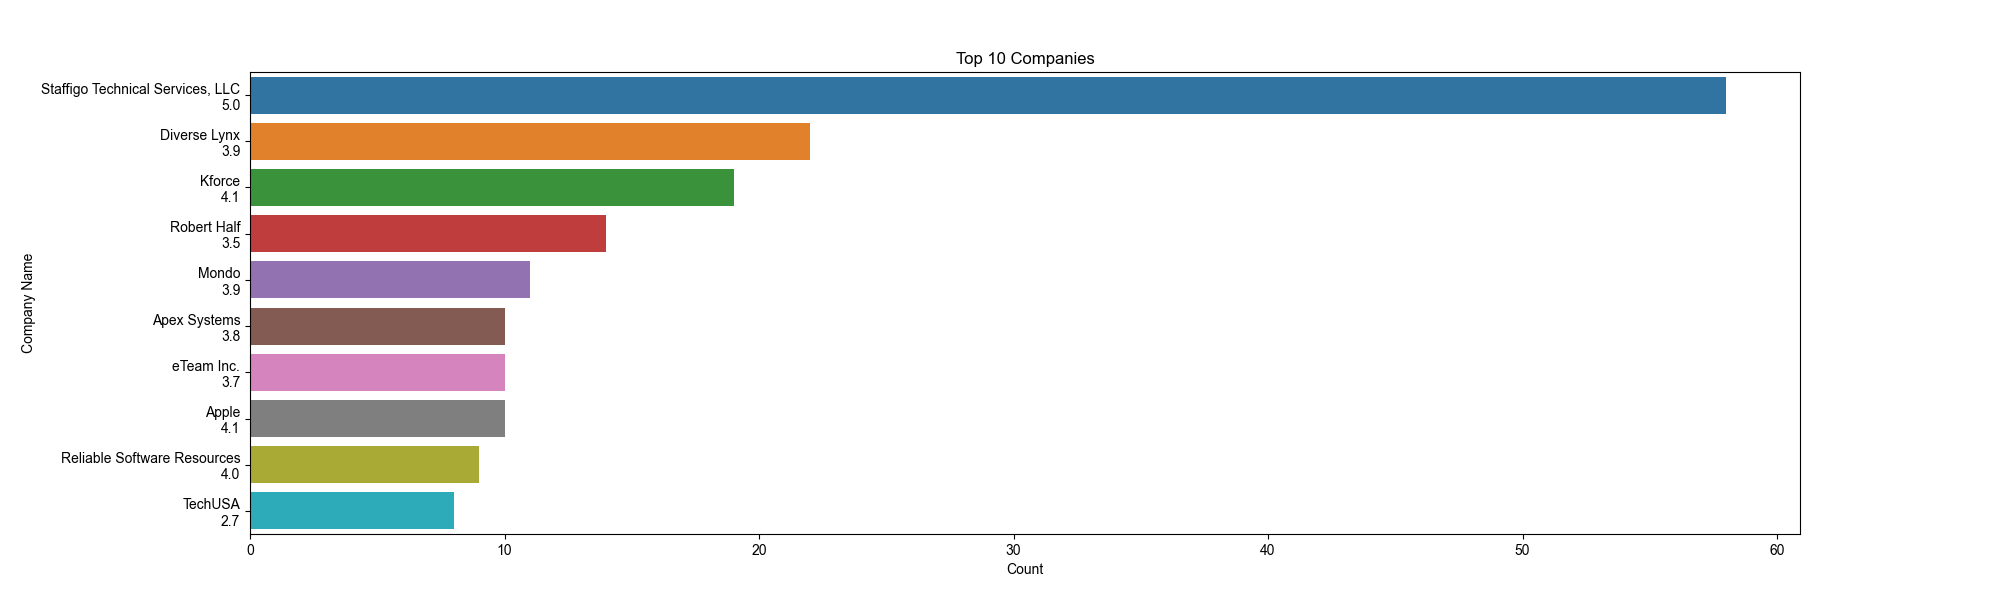

In [27]:
plt.figure(figsize=(20,6))
g = sns.countplot(y='Company Name', data=dataset, order = dataset['Company Name'].value_counts().nlargest(10).index)
p = plt.title('Top 10 Companies')
p = plt.xlabel('Count')
p = plt.ylabel('Company Name')

In [28]:
def companyProcesser(company):
    company = company[:-4]
    return company

In [29]:
dataset['Company Name'] = dataset['Company Name'].apply(companyProcesser)
print(dataset['Company Name'].value_counts().nlargest(10))
print("Company Name values: ",dataset['Company Name'].value_counts().size)

Staffigo Technical Services, LLC    58
Diverse Lynx                        22
Kforce                              19
Robert Half                         14
Mondo                               14
Apple                               10
eTeam Inc.                          10
Apex Systems                        10
Reliable Software Resources          9
TechUSA                              8
Name: Company Name, dtype: int64
Company Name values:  978


As we can see at first sight the top 10 companies are the same as before but we have 8 less unique values. This happens because there were companies names that had different rating values at the end of the name.

The next attribute is Location, is a string but at this point I will not do anything with it. Later on this attribute will be converted to a number in order to make the predictive model.

In [30]:
dataset['Location'].value_counts()

New York, NY           203
Chicago, IL             88
San Francisco, CA       87
Austin, TX              61
Los Angeles, CA         56
                      ... 
Itasca, IL               1
Northlake, IL            1
Rolling Meadows, IL      1
Whittier, CA             1
Littleton, CO            1
Name: Location, Length: 206, dtype: int64

Let's focus on Size attribute.

In [31]:
dataset['Size'].value_counts()

10000+ employees           364
1001 to 5000 employees     316
51 to 200 employees        294
201 to 500 employees       208
501 to 1000 employees      191
1 to 50 employees           97
5001 to 10000 employees     87
Unknown                      2
Name: Size, dtype: int64

The number of unique values is not that big so let's move on and convert this attribute later to number.

The next attributes are Founded, that is a numerical value so nothing will be done now, and Type of Ownership. Thinking about this last one I have concluded that this attribute has no value for me so I am going to delete the whole attribute.

In [32]:
dataset = dataset.drop(['Type of ownership'],axis=1)
dataset.head()

Job Title  Salary Estimate  Rating                        Company Name  \
0  Data Analyst            52000    3.20           Vera Institute of Justice   
1  Data Analyst            52000    3.80  Visiting Nurse Service of New York   
2  Data Analyst            52000    3.40                         Squarespace   
3  Data Analyst            52000    4.10                            Celerity   
4  Data Analyst            52000    3.90                             FanDuel   

       Location                    Size  Founded  \
0  New York, NY    201 to 500 employees  1961.00   
1  New York, NY        10000+ employees  1893.00   
2  New York, NY  1001 to 5000 employees  2003.00   
3  New York, NY    201 to 500 employees  2002.00   
4  New York, NY   501 to 1000 employees  2009.00   

                           Industry                            Sector  \
0                 Social Assistance                        Non-Profit   
1  Health Care Services & Hospitals                       Health Care   
2                          Internet            Information Technology   
3                       IT Services            Information Technology   
4               Sports & Recreation  Arts, Entertainment & Recreation   

                      Revenue Job Seniority  
0  $100 to $500 million (USD)         OTHER  
1      $2 to $5 billion (USD)         OTHER  
2    Unknown / Non-Applicable            SR  
3   $50 to $100 million (USD)         OTHER  
4  $100 to $500 million (USD)         OTHER

Now we head to Industry and Sector, two attributes that look very similar. Industry refers to the specific part of the sector meanwhile sector is more a general concept. Later on I will decide which attribute I will be using for the regression model.

In [33]:
dataset['Industry'].value_counts()

IT Services                              278
Staffing & Outsourcing                   267
Health Care Services & Hospitals         132
Computer Hardware & Software              88
Investment Banking & Asset Management     76
                                        ... 
Truck Rental & Leasing                     1
Chemical Manufacturing                     1
Pet & Pet Supplies Stores                  1
Express Delivery Services                  1
Hotels, Motels, & Resorts                  1
Name: Industry, Length: 81, dtype: int64

In [34]:
dataset['Sector'].value_counts()

Information Technology                491
Business Services                     402
Finance                               160
Health Care                           132
Education                              47
Insurance                              46
Media                                  36
Manufacturing                          35
Retail                                 34
Biotech & Pharmaceuticals              31
Government                             23
Aerospace & Defense                    21
Non-Profit                             19
Transportation & Logistics             18
Oil, Gas, Energy & Utilities           12
Accounting & Legal                     11
Real Estate                            10
Telecommunications                     10
Construction, Repair & Maintenance      7
Arts, Entertainment & Recreation        6
Consumer Services                       5
Restaurants, Bars & Food Services       2
Travel & Tourism                        1
Name: Sector, dtype: int64

Finally the last attribute, revenue. This attribute is similar to salary because it expresses a numerical value but is represented as a string.

In [35]:
def revenueProcessor(revenue):
    revenue = revenue.replace(' (USD)','')
    revenue = revenue.replace(' / Non-Applicable','')
    return revenue

In [36]:
dataset['Revenue'] = dataset['Revenue'].apply(revenueProcessor)
dataset['Revenue'].value_counts()

Unknown                       353
$100 to $500 million          207
$50 to $100 million           191
$10+ billion                  186
$2 to $5 billion              127
$10 to $25 million            112
$25 to $50 million             90
$1 to $2 billion               86
$500 million to $1 billion     75
$5 to $10 billion              56
$1 to $5 million               40
$5 to $10 million              26
Less than $1 million           10
Name: Revenue, dtype: int64

<IPython.core.display.Javascript object>


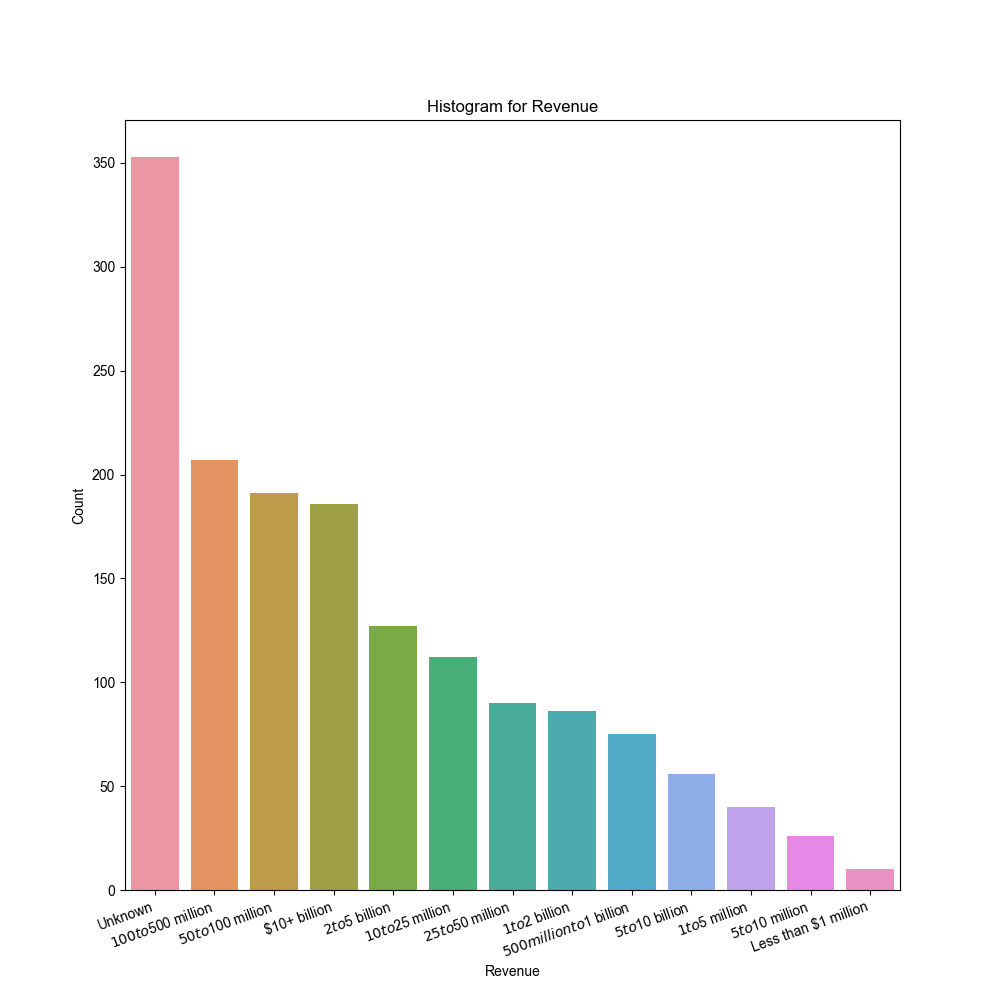

In [37]:
plt.figure(figsize=(10,10))
g = sns.countplot(x='Revenue', data=dataset, order = dataset['Revenue'].value_counts().index)
p = plt.title('Histogram for Revenue')
p = plt.xlabel('Revenue')
p = plt.ylabel('Count')
p = g.set_xticklabels(g.get_xticklabels(), rotation=20, horizontalalignment='right')

All attributes have now been processed but there is one last thing to do, last but not least. Attributes have to be numerical in order to do the regression model so let's have a look which columns are not numerical.

In [38]:
printColumnTypes(dataset)

Job Title <class 'str'>
Salary Estimate <class 'numpy.int64'>
Rating <class 'numpy.float64'>
Company Name <class 'str'>
Location <class 'str'>
Size <class 'str'>
Founded <class 'numpy.float64'>
Industry <class 'str'>
Sector <class 'str'>
Revenue <class 'str'>
Job Seniority <class 'str'>
-------------------------------------------------------
(1559, 11)


As you can see the majority of attributes are strings. There are different ways to make this conversion like mapping the values or using an encoder. In my case I will be using LabelEncoder function from sklearn. Let's have a look of how does this function work.

In [39]:
labelEncoder = preprocessing.LabelEncoder()
dataset['Job Title'] = labelEncoder.fit_transform(dataset['Job Title'])
dataset['Company Name'] = labelEncoder.fit_transform(dataset['Company Name'])
dataset['Location'] = labelEncoder.fit_transform(dataset['Location'])
dataset['Size'] = labelEncoder.fit_transform(dataset['Size'])
dataset['Industry'] = labelEncoder.fit_transform(dataset['Industry'])
dataset['Sector'] = labelEncoder.fit_transform(dataset['Sector'])
dataset['Revenue'] = labelEncoder.fit_transform(dataset['Revenue'])
dataset['Job Seniority'] = labelEncoder.fit_transform(dataset['Job Seniority'])

In [40]:
printColumnTypes(dataset)
dataset[0:10]

Job Title <class 'numpy.int32'>
Salary Estimate <class 'numpy.int64'>
Rating <class 'numpy.float64'>
Company Name <class 'numpy.int32'>
Location <class 'numpy.int32'>
Size <class 'numpy.int32'>
Founded <class 'numpy.float64'>
Industry <class 'numpy.int32'>
Sector <class 'numpy.int32'>
Revenue <class 'numpy.int32'>
Job Seniority <class 'numpy.int32'>
-------------------------------------------------------
(1559, 11)


Job Title  Salary Estimate  Rating  Company Name  Location  Size  Founded  \
0          0            52000    3.20           913       129     3  1961.00   
1          0            52000    3.80           924       129     1  1893.00   
2          0            52000    3.40           760       129     2  2003.00   
3          0            52000    4.10           153       129     3  2002.00   
4          0            52000    3.90           288       129     5  2009.00   
5          0            52000    3.90           643       129     2  2014.00   
6          0            52000    4.40           864       129     2  2001.00   
7          4            52000    3.70           321       129     3  1914.00   
8          0            52000    4.00           223       129     4  1896.00   
9          0            52000    4.40           689       129     5  2013.00   

   Industry  Sector  Revenue  Job Seniority  
0        64      15        4              1  
1        36      10        5              1  
2        45      11       12              2  
3        41      11        9              1  
4        66       2        4              1  
5        46       8       12              1  
6        46       8       12              1  
7        44      12        4              1  
8        78       8        0              1  
9        62       4       12              1

Now all the attributes are numerical so we can affirm that our preprocessing stage is done.

# 5. First Regressions

In [41]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


In [42]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

In [43]:
def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

In [44]:
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

The target attribute is Salary Estimate so let's see its histogram and check if it has a Gaussian distribution.

<IPython.core.display.Javascript object>


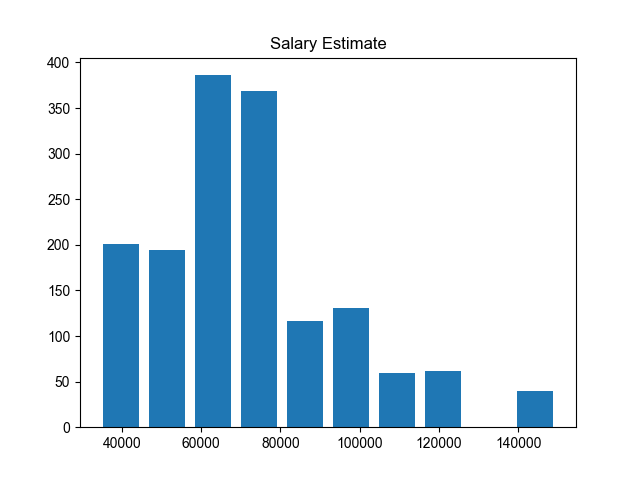

array([[<AxesSubplot: title={'center': 'Salary Estimate'}>]], dtype=object)

In [45]:
dataset.hist(column='Salary Estimate', grid = False, rwidth=0.8)

One important thing is to see the correlation between attributes.

<IPython.core.display.Javascript object>


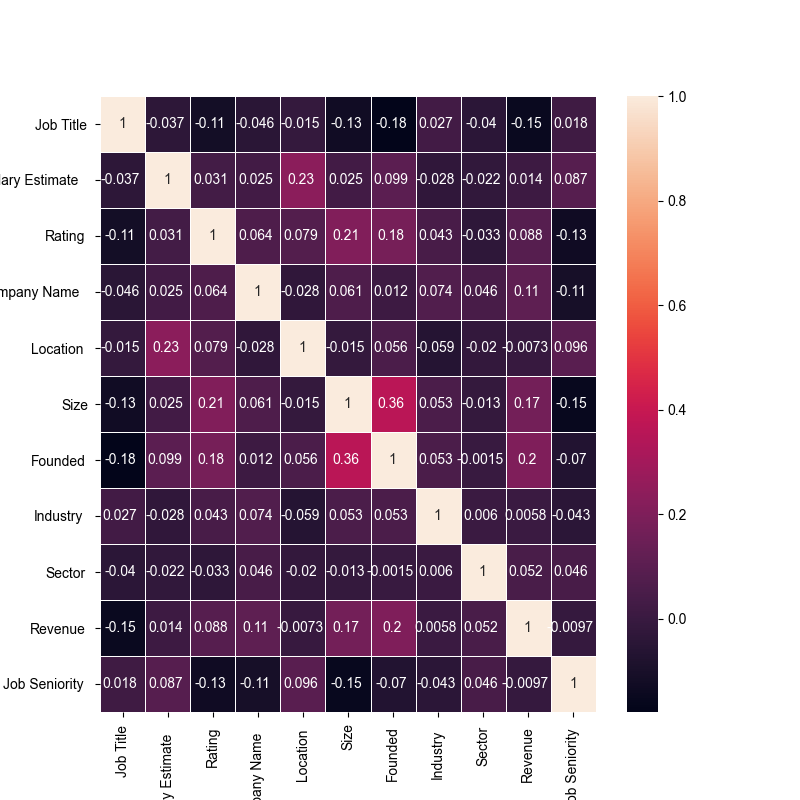

In [46]:
correlacio = dataset.corr()

plt.figure(figsize=(8,8))

ax = sns.heatmap(correlacio, annot=True, linewidths=.7)
ax.get_figure().savefig("images/correlacioHeatMap.png")

As you can see the correlations are really low. This could have a major impact in the regression models, let's check it. As It was mentioned before I am going to delete Sector attribute. The number of unique values in Industry is lower so I am going to keep Industry attribute despite it has a worse correlation. The correlations are so bad in the two attributes that has no impact in the result.

In [47]:
dataset = dataset.drop(['Sector'],axis=1)

Now I am going to select the attribute to predict. In this case it will be Salary Estimate

In [48]:
dataset.head()

Job Title  Salary Estimate  Rating  Company Name  Location  Size  Founded  \
0          0            52000    3.20           913       129     3  1961.00   
1          0            52000    3.80           924       129     1  1893.00   
2          0            52000    3.40           760       129     2  2003.00   
3          0            52000    4.10           153       129     3  2002.00   
4          0            52000    3.90           288       129     5  2009.00   

   Industry  Revenue  Job Seniority  
0        64        4              1  
1        36        5              1  
2        45       12              2  
3        41        9              1  
4        66        4              1

In [49]:
salary = dataset['Salary Estimate']
dataset = dataset.drop(['Salary Estimate'], axis = 1)
dataset.insert(loc=9, column='Salary Estimate', value=salary)
dataset[0:10]

Job Title  Rating  Company Name  Location  Size  Founded  Industry  \
0          0    3.20           913       129     3  1961.00        64   
1          0    3.80           924       129     1  1893.00        36   
2          0    3.40           760       129     2  2003.00        45   
3          0    4.10           153       129     3  2002.00        41   
4          0    3.90           288       129     5  2009.00        66   
5          0    3.90           643       129     2  2014.00        46   
6          0    4.40           864       129     2  2001.00        46   
7          4    3.70           321       129     3  1914.00        44   
8          0    4.00           223       129     4  1896.00        78   
9          0    4.40           689       129     5  2013.00        62   

   Revenue  Job Seniority  Salary Estimate  
0        4              1            52000  
1        5              1            52000  
2       12              2            52000  
3        9              1            52000  
4        4              1            52000  
5       12              1            52000  
6       12              1            52000  
7        4              1            52000  
8        0              1            52000  
9       12              1            52000

In [50]:
X_X = dataset.drop(['Salary Estimate'],axis=1).values
Y = dataset['Salary Estimate']
index = dataset.columns[:12]
data = dataset.values

print(X_X)
print (Y)

[[  0.    3.2 913.  ...  64.    4.    1. ]
 [  0.    3.8 924.  ...  36.    5.    1. ]
 [  0.    3.4 760.  ...  45.   12.    2. ]
 ...
 [  0.    2.9  69.  ...  80.    3.    2. ]
 [  0.    3.1 195.  ...  25.    6.    1. ]
 [  0.    3.4 708.  ...  36.    5.    2. ]]
0       52000
1       52000
2       52000
3       52000
4       52000
        ...  
1554    91000
1555    91000
1556    91000
1557    91000
1558    91000
Name: Salary Estimate, Length: 1559, dtype: int64


Standarization helps to see the attributes in a same scale each other.

<IPython.core.display.Javascript object>


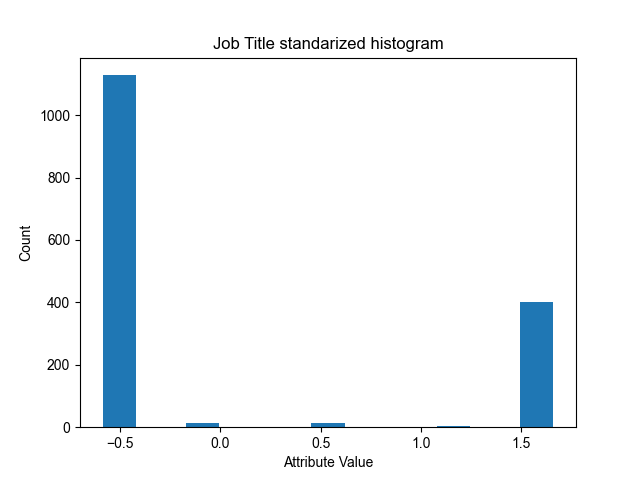

<IPython.core.display.Javascript object>


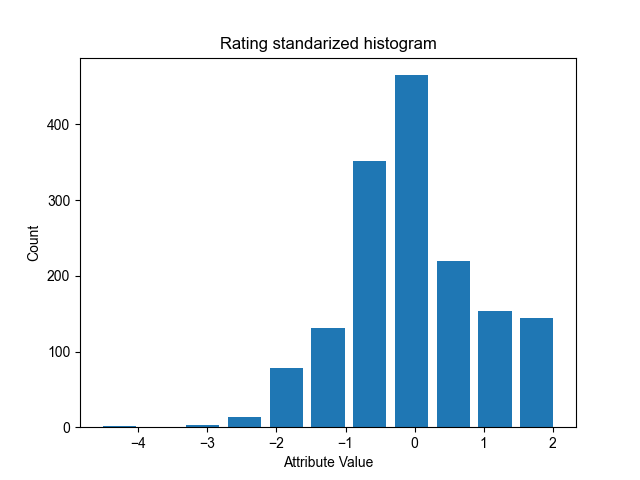

<IPython.core.display.Javascript object>


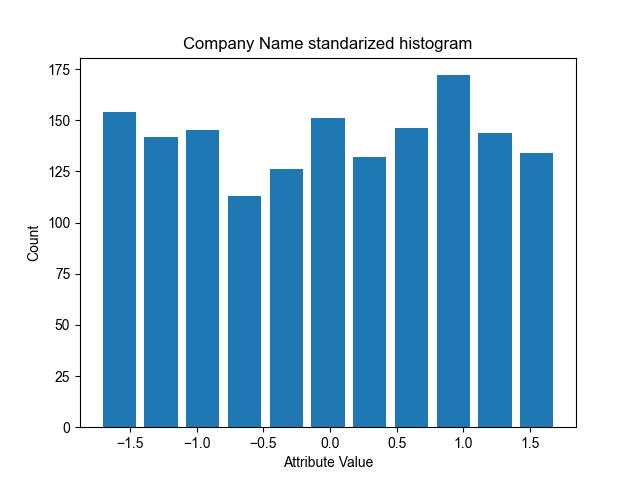

<IPython.core.display.Javascript object>


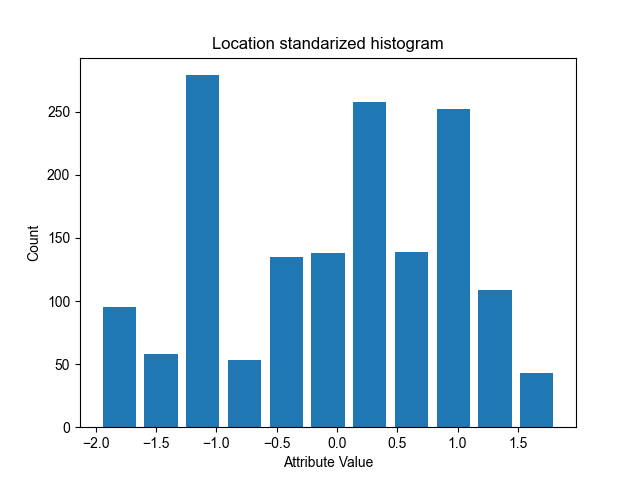

<IPython.core.display.Javascript object>


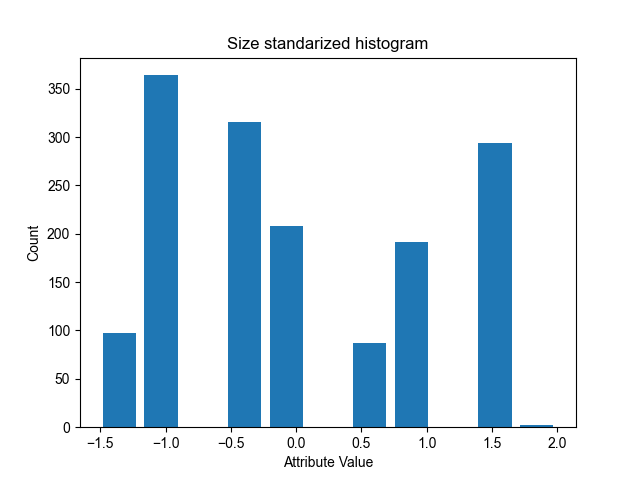

<IPython.core.display.Javascript object>


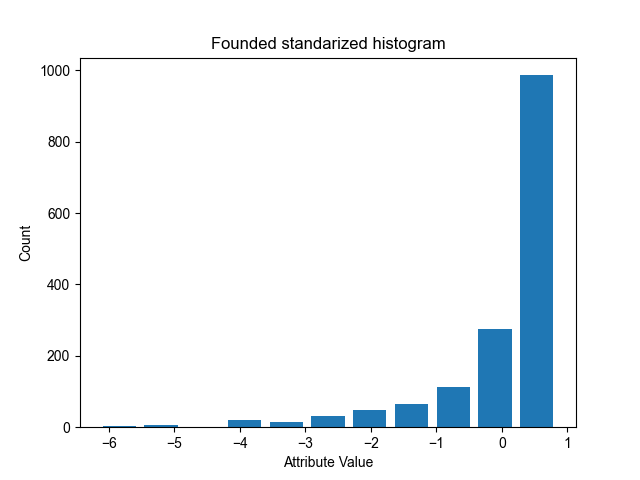

<IPython.core.display.Javascript object>


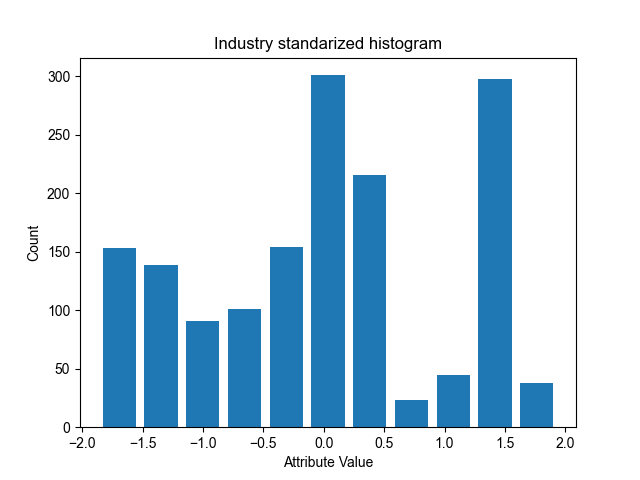

<IPython.core.display.Javascript object>


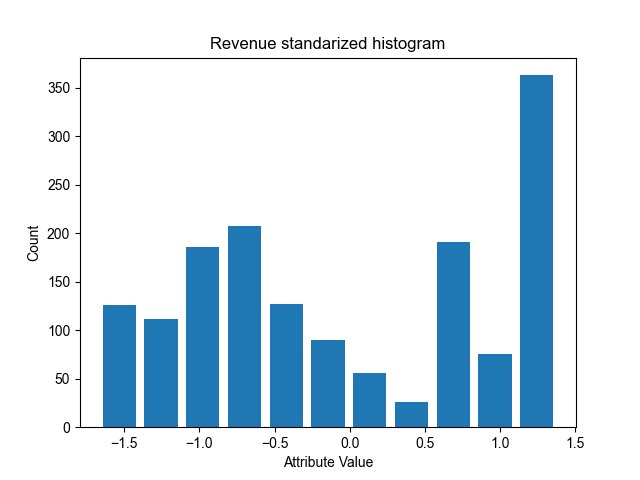

<IPython.core.display.Javascript object>


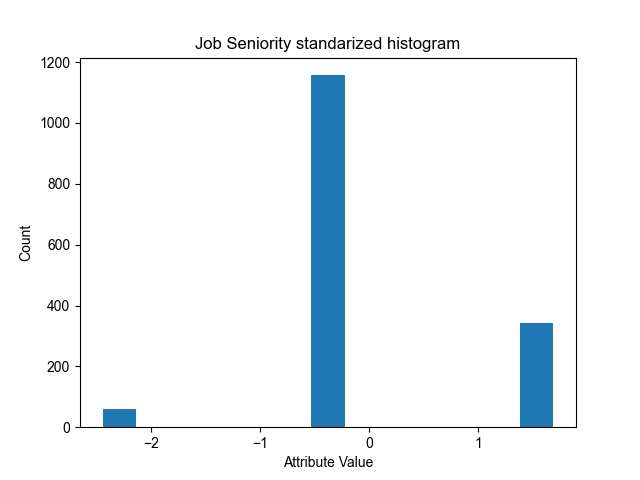

In [51]:
for i in range(X_X.shape[1]):
    plt.figure()
    plt.title("{} standarized histogram".format(str(index[i])))
    plt.xlabel("Attribute Value")
    plt.ylabel("Count")
    x_t = standarize(X_X)
    hist = plt.hist(x_t[:,i], bins=11, range=[np.min(x_t[:,i]), np.max(x_t[:,i])], histtype="bar", rwidth=0.8)

The following graphics will show the regressions of each value to the attribute to predict without standarization.

<IPython.core.display.Javascript object>


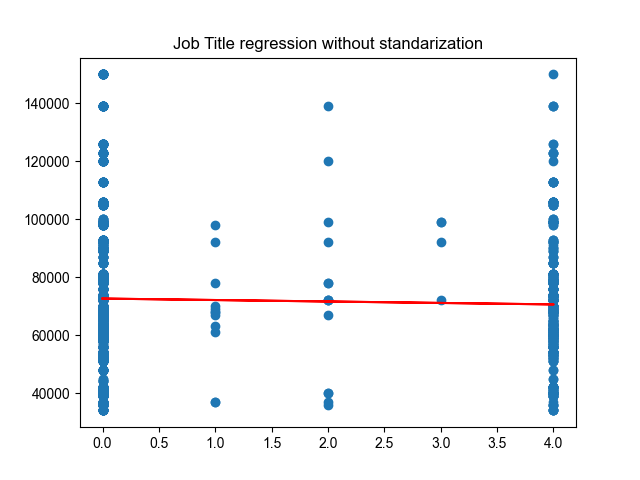

Mean squeared error:  567469224.9262372
R2 score:  0.001365845837010271


<IPython.core.display.Javascript object>


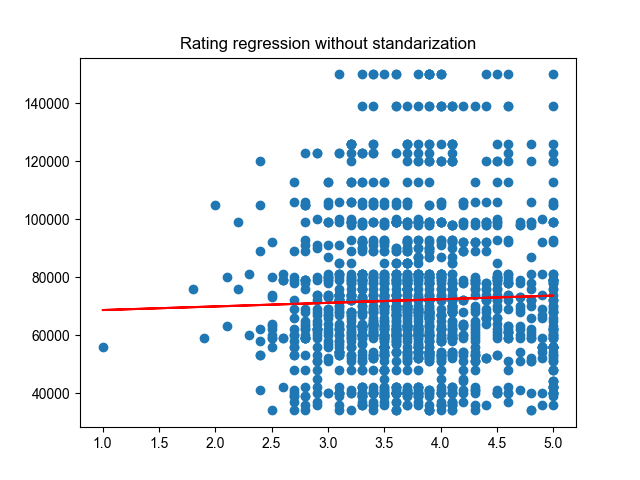

Mean squeared error:  567683463.1529208
R2 score:  0.0009888287215511493


<IPython.core.display.Javascript object>


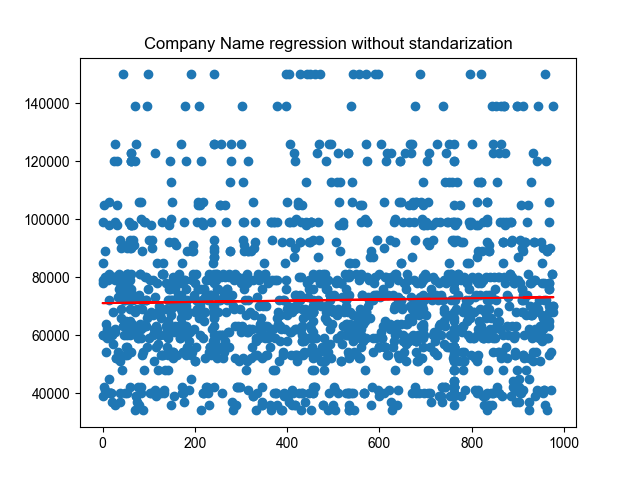

Mean squeared error:  567887226.7046012
R2 score:  0.000630244972612104


<IPython.core.display.Javascript object>


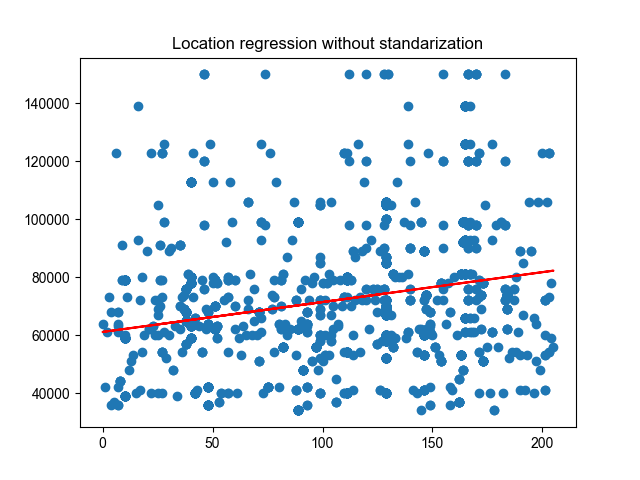

Mean squeared error:  537335720.4970478
R2 score:  0.054394883158852436


<IPython.core.display.Javascript object>


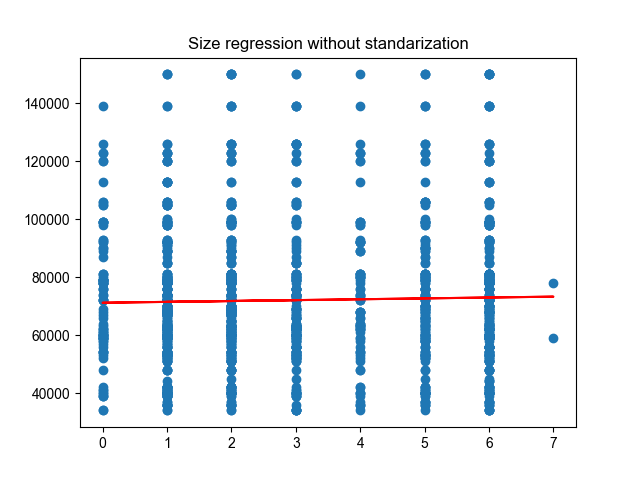

Mean squeared error:  567886979.9134992
R2 score:  0.0006306792763814961


C:\Users\gma01\AppData\Local\Temp\ipykernel_21244\2425947403.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


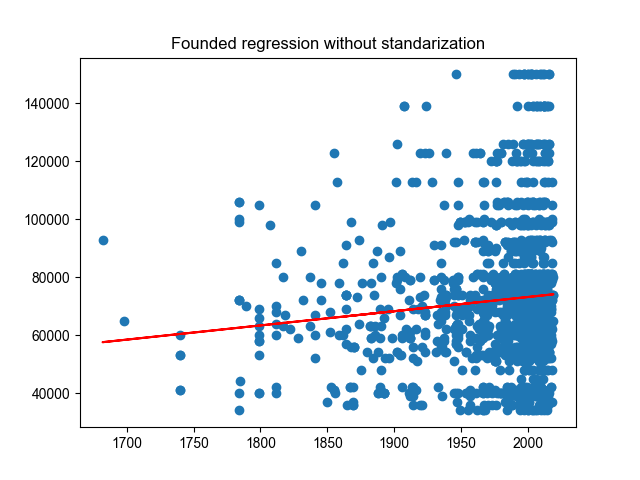

Mean squeared error:  562680950.4021386
R2 score:  0.009792266635239466


<IPython.core.display.Javascript object>


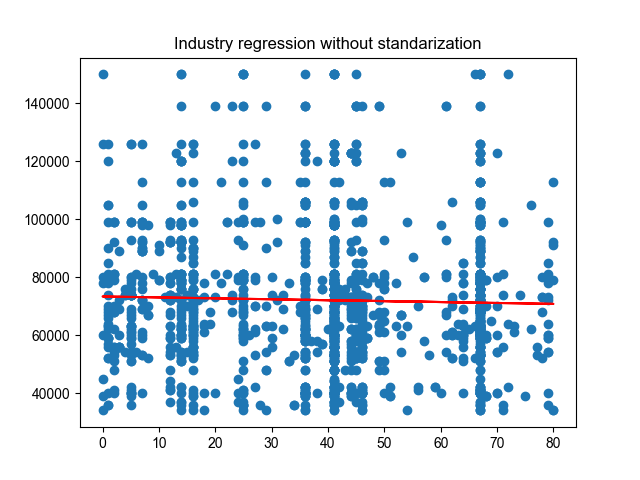

Mean squeared error:  567793690.6125228
R2 score:  0.00079485008614677


<IPython.core.display.Javascript object>


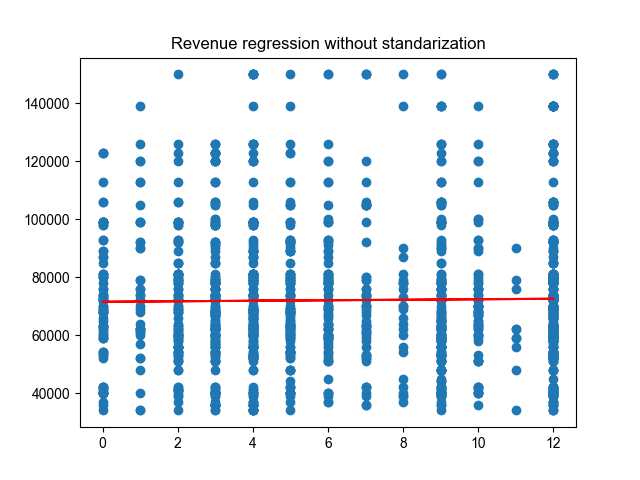

Mean squeared error:  568128343.0233186
R2 score:  0.00020592770496008495


<IPython.core.display.Javascript object>


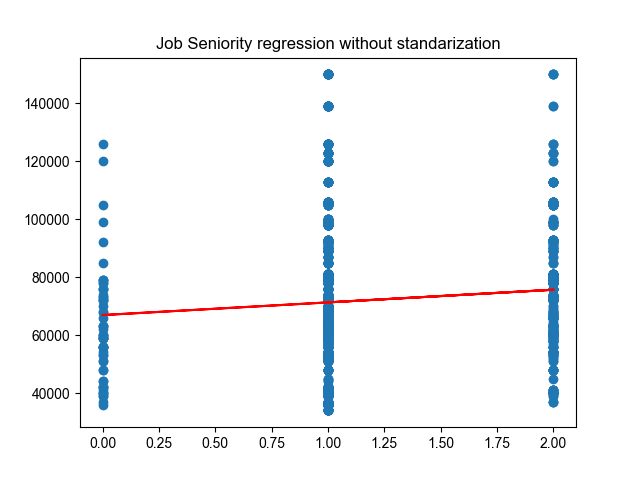

Mean squeared error:  563923807.5002997
R2 score:  0.00760508274499605


In [52]:
for att in range(X_X.shape[1]):
    attr1 = X_X[:,att].reshape(X_X.shape[0], 1) 
    regr = regression(attr1, Y) 
    predicted = regr.predict(attr1)
    plt.figure()
    plt.title("{} regression without standarization".format(index[att]))
    ax = plt.scatter(X_X[:,att], Y)
    plt.plot(attr1[:,0], predicted, 'r')
    MSE = mse(Y, predicted)
    r2 = r2_score(Y, predicted)

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)

The MSE and the R2 values for every attribute are really bad mainly to the categorical origin of the attributes that were in the dataset. Let's see if the MSE and R2 values with standarized attributes change the actual regressions.

<IPython.core.display.Javascript object>


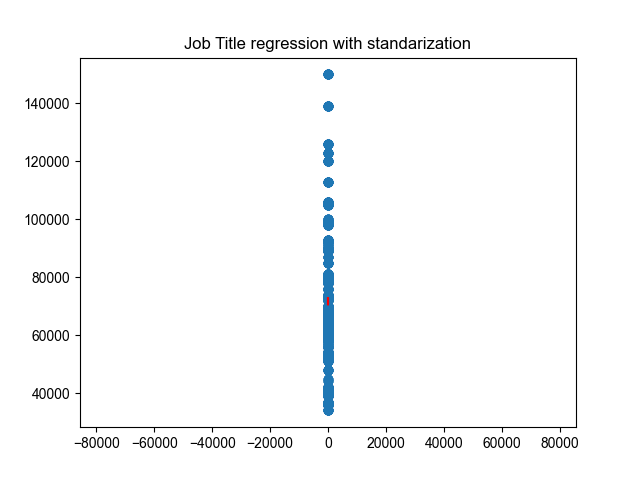

Mean squeared error:  567469224.9262372
R2 score:  0.001365845837010271


<IPython.core.display.Javascript object>


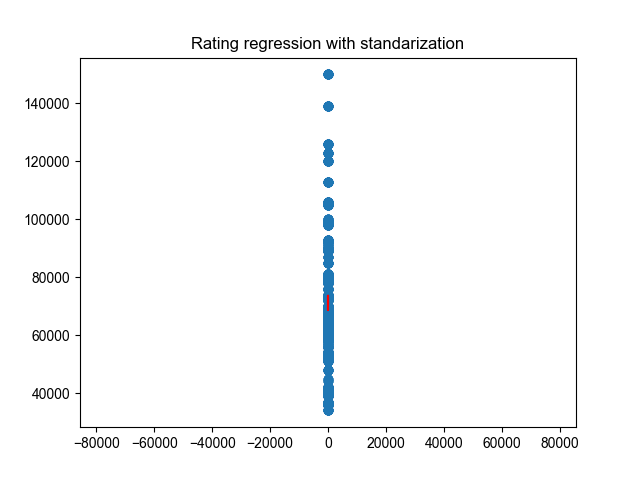

Mean squeared error:  567683463.1529208
R2 score:  0.0009888287215511493


<IPython.core.display.Javascript object>


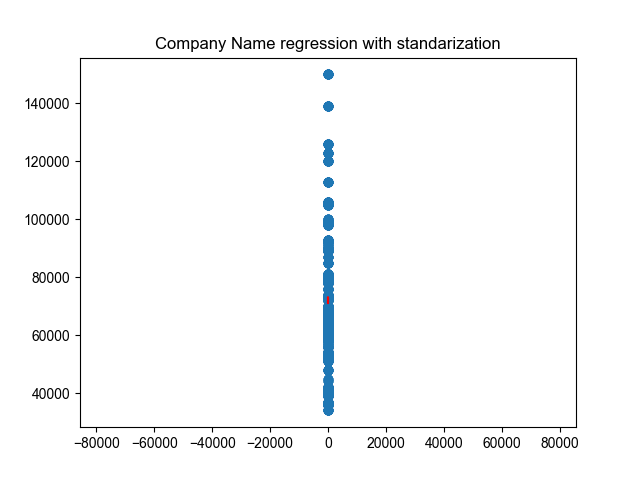

Mean squeared error:  567887226.7046012
R2 score:  0.000630244972612104


<IPython.core.display.Javascript object>


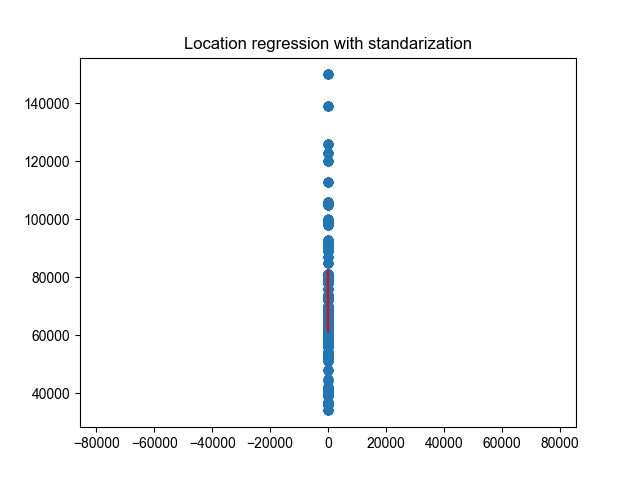

Mean squeared error:  537335720.4970479
R2 score:  0.054394883158852325


<IPython.core.display.Javascript object>


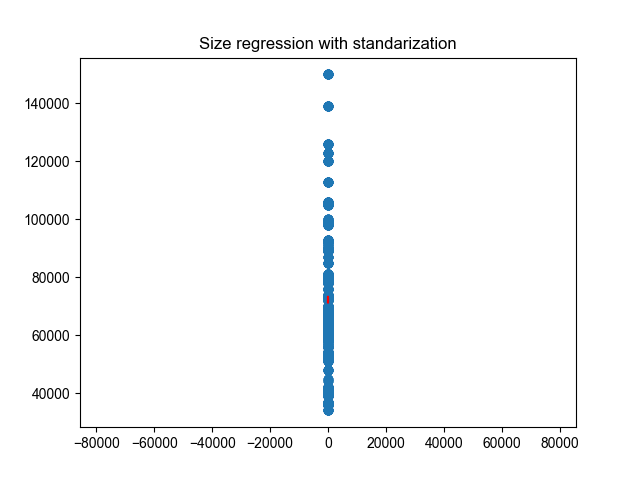

Mean squeared error:  567886979.9134992
R2 score:  0.0006306792763814961


<IPython.core.display.Javascript object>


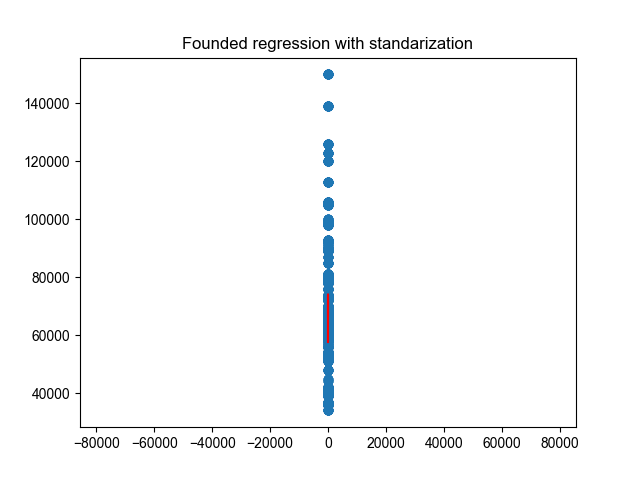

Mean squeared error:  562680950.4021386
R2 score:  0.009792266635239466


<IPython.core.display.Javascript object>


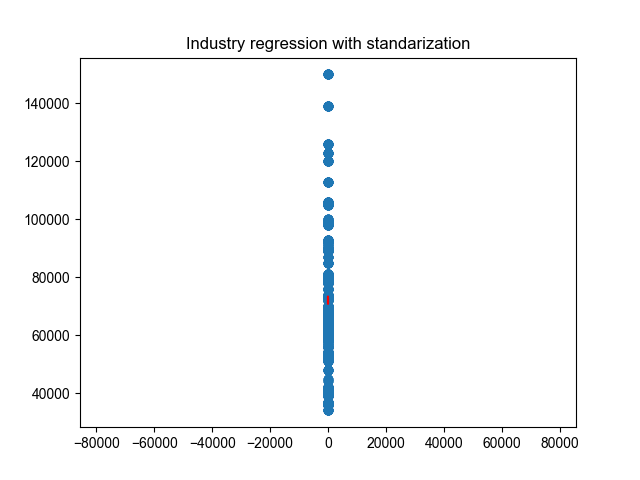

Mean squeared error:  567793690.6125228
R2 score:  0.00079485008614677


<IPython.core.display.Javascript object>


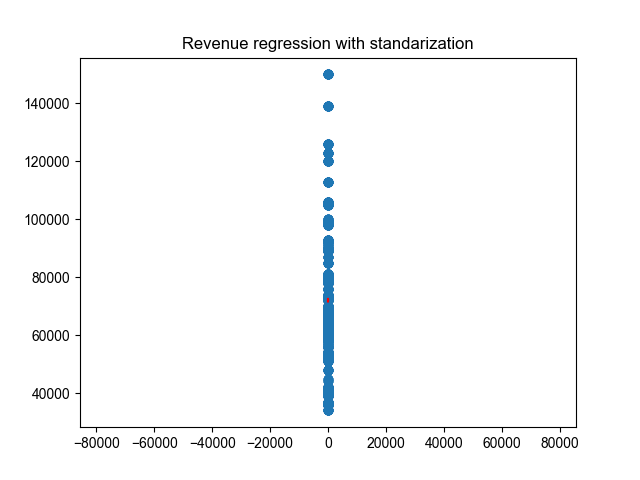

Mean squeared error:  568128343.0233186
R2 score:  0.00020592770496008495


<IPython.core.display.Javascript object>


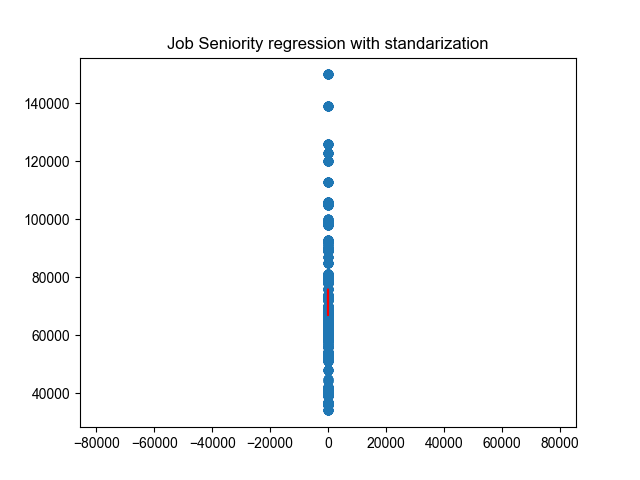

Mean squeared error:  563923807.5002997
R2 score:  0.00760508274499605


In [53]:
for i in range(X_X.shape[1]):
    att = i 
    attr1 = X_X[:, att].reshape(X_X.shape[0], 1) 
    attr1 = standarize(attr1)
    regr = regression(attr1, Y) 
    predicted = regr.predict(attr1)
    plt.figure()
    plt.title("{} regression with standarization".format(index[att]))
    ax = plt.scatter(X_X[:, 0], Y)
    plt.plot(attr1[:, 0], predicted, 'r')   
    plt.axis('equal')
    MSE = mse(Y, predicted)
    r2 = r2_score(Y, predicted)

    print("Mean squeared error: ", MSE)
    print("R2 score: ", r2)

As you can see the values are completely the same. Even though let's see how the model works.

In [54]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = split_data(X_X, Y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] 
    x_v = x_val[:,i] 
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))
    
    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v))
    r2 = r2_score(y_val, regr.predict(x_v))

    
    print("Error in %s (%d): %f" %(str(index[i]), i, error))
    print("R2 score in %s (%d): %f" %(str(index[i]), i, r2))
    print("---")

Error in Job Title (0): 511184456.855097
R2 score in Job Title (0): 0.003370
---
Error in Rating (1): 514034082.137507
R2 score in Rating (1): -0.002185
---
Error in Company Name (2): 512959891.989566
R2 score in Company Name (2): -0.000091
---
Error in Location (3): 485138240.792388
R2 score in Location (3): 0.054151
---
Error in Size (4): 512278749.230657
R2 score in Size (4): 0.001237
---
Error in Founded (5): 510524298.448979
R2 score in Founded (5): 0.004658
---
Error in Industry (6): 512976631.490983
R2 score in Industry (6): -0.000124
---
Error in Revenue (7): 513092558.586380
R2 score in Revenue (7): -0.000350
---
Error in Job Seniority (8): 511245294.181664
R2 score in Job Seniority (8): 0.003252
---


My regressor is truly garbage. I am going to try a multiple linear regression and check the Normalized Mean Squared Error. The difference between NRMSE and MSE is the units of the error that is in the same units as the attribute to predict.

In [55]:
# Fitting Multiple Linear Regression to the Training set
df = dataset.drop(['Salary Estimate'], axis=1)
X_X = df.values
lr = LinearRegression()
cv = cross_val_score(lr, X_X, Y, cv=10, scoring='neg_root_mean_squared_error')
print('Average NRMSE: {}'.format(round(cv.mean(), 5)))
print('Standard Deviation: {}'.format(round(cv.std(), 5)))

Average NRMSE: -22963.9327
Standard Deviation: 6798.89667


<IPython.core.display.Javascript object>


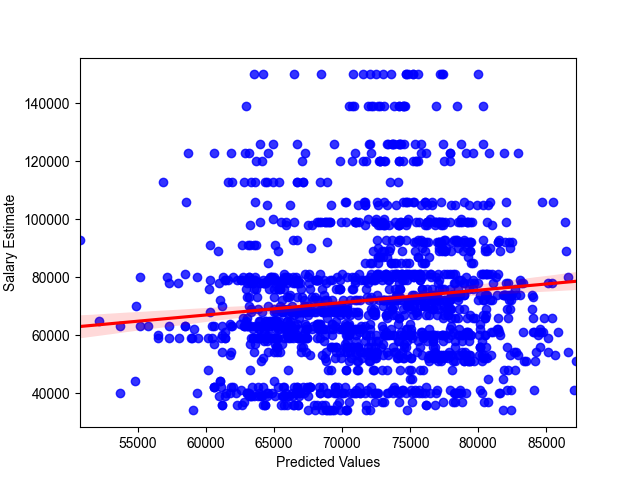

[Text(0.5, 0, 'Predicted Values')]

In [56]:
cvp = cross_val_predict(lr, X_X, Y, cv=10)
plt.figure()
ax = sns.regplot(x=cvp, y=Y, scatter_kws={"color": "blue"}, line_kws={"color":"red"})
ax.set(xlabel = "Predicted Values")

There is a function that evaluates a lot of model regressors to find which one fits the best.

In [57]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_X, Y,test_size=.4,random_state=123)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:50<00:00,  1.19s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.14       0.15  22436.39   
RandomForestRegressor                        0.12       0.13  22756.24   
AdaBoostRegressor                            0.11       0.13  22795.66   
HistGradientBoostingRegressor                0.08       0.10  23147.28   
ExtraTreesRegressor                          0.07       0.08  23349.29   
LGBMRegressor                                0.07       0.08  23370.11   
BaggingRegressor                             0.05       0.06  23610.64   
LassoLarsCV                                  0.03       0.04  23854.90   
LarsCV                                       0.03       0.04  23854.90   
LassoLarsIC                                  0.03       0.04  23855.63   
LassoCV                                      0.03       0.04  23858.89   
ElasticNet                                   0.03       0.04  23860.09   
BayesianRidge                                0.03       0.04  23866.90   
OrthogonalMatchingPursuitCV                  0.03       0.04  23878.67   
OrthogonalMatchingPursuit                    0.03       0.04  23883.37   
LassoLars                                    0.02       0.04  23895.28   
RidgeCV                                      0.02       0.04  23897.76   
SGDRegressor                                 0.02       0.04  23901.24   
Ridge                                        0.02       0.04  23901.60   
Lasso                                        0.02       0.04  23901.81   
Lars                                         0.02       0.04  23902.04   
TransformedTargetRegressor                   0.02       0.04  23902.04   
LinearRegression                             0.02       0.04  23902.04   
XGBRegressor                                 0.02       0.04  23906.43   
PoissonRegressor                             0.02       0.04  23909.76   
TweedieRegressor                             0.02       0.04  23914.13   
GammaRegressor                               0.02       0.04  23933.51   
HuberRegressor                               0.00       0.02  24135.90   
PassiveAggressiveRegressor                   0.00       0.02  24164.09   
ElasticNetCV                                -0.00       0.01  24215.00   
DummyRegressor                              -0.02      -0.00  24420.24   
SVR                                         -0.06      -0.04  24875.58   
NuSVR                                       -0.06      -0.04  24877.00   
QuantileRegressor                           -0.06      -0.04  24879.76   
KNeighborsRegressor                         -0.11      -0.09  25434.95   
RANSACRegressor                             -0.34      -0.32  27999.31   
ExtraTreeRegressor                          -0.53      -0.51  29897.77   
DecisionTreeRegressor                       -0.54      -0.51  29975.82   
LinearSVR                                   -8.89      -8.75  76081.80   
KernelRidge                                 -8.96      -8.82  76353.91   
MLPRegressor                                -9.03      -8.89  76631.61   
GaussianProcessRegressor                 -1607.22   -1583.98 970235.05   

                               Time Taken  
Model                                      
GradientBoostingRegressor            0.28  
RandomForestRegressor                0.67  
AdaBoostRegressor                    0.11  
HistGradientBoostingRegressor        1.72  
ExtraTreesRegressor                  0.70  
LGBMRegressor                        0.21  
BaggingRegressor                     0.10  
LassoLarsCV                          0.04  
LarsCV                               0.04  
LassoLarsIC                          0.02  
LassoCV                              0.12  
ElasticNet                           0.02  
BayesianRidge                        0.03  
OrthogonalMatchingPursuitCV          0.05  
OrthogonalMatchingPursuit            0.02  
LassoLars                 

After seeing this result I have concluded that a regression model is not optimal for my dataset. As I mentioned before the ultra-low correlation between the attributes was an indicator of the result that I was going to see later. I think that this bad results can be related also to the few number of rows that are in the dataset. To try a desperate solution for the regression I am going to try and quadruplicate the number of rows to see if there is an improvement or it is not.

In [58]:
extendedDataset = pd.concat([dataset]*3, ignore_index=True) 
extendedDataset.shape

(4677, 10)

In [59]:
exX = extendedDataset.drop(['Salary Estimate'],axis=1).values
exY = extendedDataset['Salary Estimate']

<IPython.core.display.Javascript object>


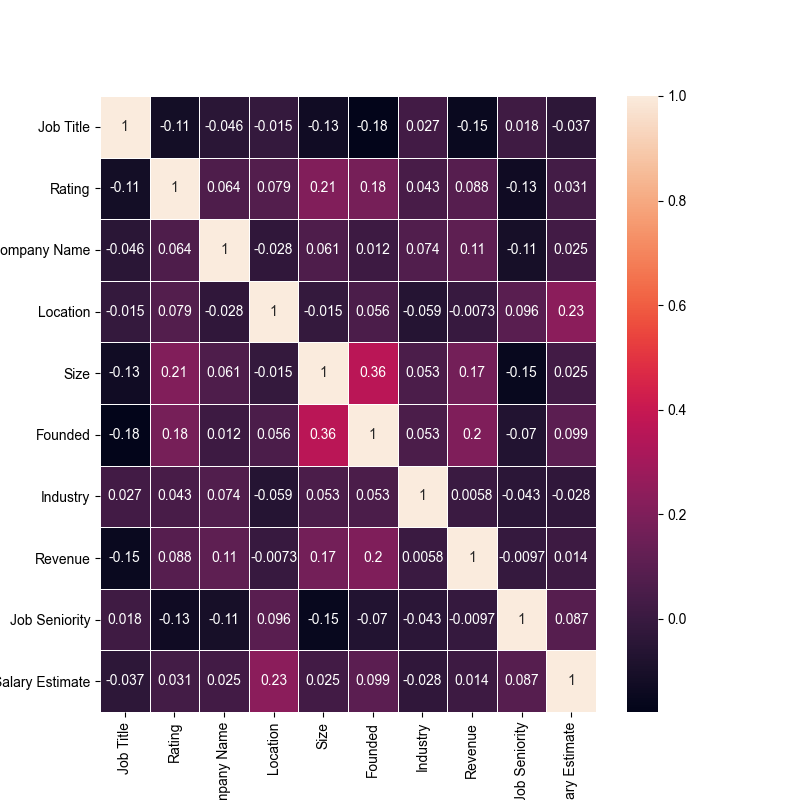

In [60]:
correlacio = extendedDataset.corr()

plt.figure(figsize=(8,8))

ax = sns.heatmap(correlacio, annot=True, linewidths=.7)
ax.get_figure().savefig("images/exCorrelacioHeatMap.png")

It seems that, with the dataset extension, the attributes now have better correlation. Let's see if the models also generate better results.

In [61]:
lr = LinearRegression()
cv = cross_val_score(lr, exX, exY, cv=10, scoring='neg_root_mean_squared_error')
print('--- Average NRMSE: {} ---'.format(round(cv.mean(), 5)))
print('Standard Deviation: {}'.format(round(cv.std(), 5)))

--- Average NRMSE: -23143.69618 ---
Standard Deviation: 2461.84899


<IPython.core.display.Javascript object>


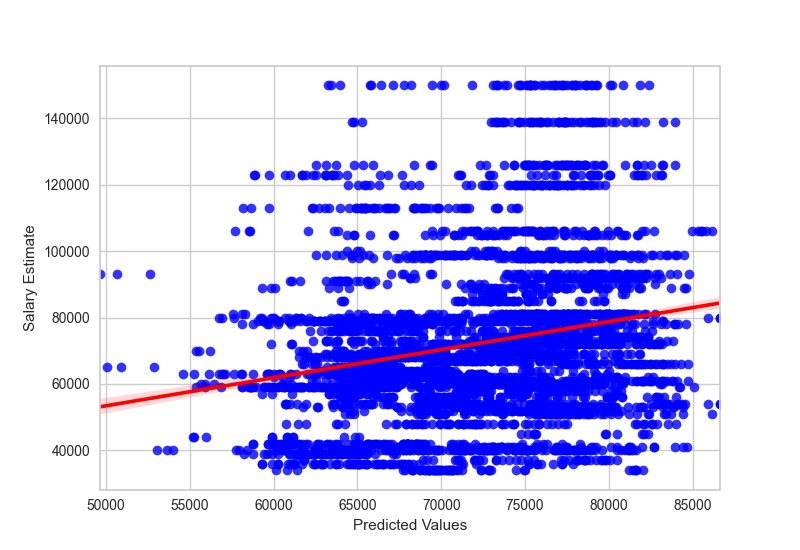

[Text(0.5, 0, 'Predicted Values')]

In [74]:
cvp = cross_val_predict(lr, exX, exY, cv=10)
plt.figure()
ax = sns.regplot(x=cvp, y=exY, scatter_kws={"color": "blue"}, line_kws={"color":"red"})
ax.set(xlabel = "Predicted Values")

In [63]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(exX, exY,test_size=.4,random_state=123)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [15:09<00:00, 21.65s/it]


Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
ExtraTreesRegressor                          0.76       0.77  11167.25   
RandomForestRegressor                        0.72       0.72  12152.05   
XGBRegressor                                 0.71       0.72  12302.67   
ExtraTreeRegressor                           0.71       0.71  12375.15   
BaggingRegressor                             0.71       0.71  12470.71   
DecisionTreeRegressor                        0.64       0.64  13750.23   
LGBMRegressor                                0.57       0.57  15160.03   
HistGradientBoostingRegressor                0.56       0.56  15289.12   
GradientBoostingRegressor                    0.35       0.36  18505.65   
KNeighborsRegressor                          0.15       0.15  21263.94   
AdaBoostRegressor                            0.08       0.09  22036.81   
HuberRegressor                               0.05       0.06  22404.91   
PassiveAggressiveRegressor                   0.05       0.05  22422.43   
ElasticNet                                   0.04       0.05  22517.27   
LassoLarsIC                                  0.04       0.05  22518.14   
BayesianRidge                                0.04       0.05  22527.41   
PoissonRegressor                             0.04       0.04  22529.99   
LassoLars                                    0.04       0.04  22534.46   
LassoCV                                      0.04       0.04  22536.08   
LassoLarsCV                                  0.04       0.04  22539.47   
LarsCV                                       0.04       0.04  22539.47   
RidgeCV                                      0.04       0.04  22540.15   
Lasso                                        0.04       0.04  22541.34   
Ridge                                        0.04       0.04  22541.35   
OrthogonalMatchingPursuitCV                  0.04       0.04  22541.44   
LinearRegression                             0.04       0.04  22541.48   
TransformedTargetRegressor                   0.04       0.04  22541.48   
Lars                                         0.04       0.04  22541.48   
GammaRegressor                               0.04       0.04  22568.81   
SGDRegressor                                 0.04       0.04  22571.94   
TweedieRegressor                             0.04       0.04  22585.38   
OrthogonalMatchingPursuit                    0.03       0.03  22702.32   
ElasticNetCV                                 0.01       0.01  22939.08   
NuSVR                                       -0.01      -0.00  23079.56   
SVR                                         -0.01      -0.00  23106.15   
QuantileRegressor                           -0.01      -0.01  23115.00   
DummyRegressor                              -0.01      -0.01  23168.10   
RANSACRegressor                             -0.47      -0.46  27847.67   
LinearSVR                                   -8.72      -8.67  71692.09   
MLPRegressor                                -8.78      -8.73  71903.98   
KernelRidge                                 -9.43      -9.38  74260.83   
GaussianProcessRegressor                 -1104.31   -1098.99 764581.43   

                               Time Taken  
Model                                      
ExtraTreesRegressor                  1.20  
RandomForestRegressor                1.98  
XGBRegressor                         0.43  
ExtraTreeRegressor                   0.02  
BaggingRegressor                     0.20  
DecisionTreeRegressor                0.04  
LGBMRegressor                        0.49  
HistGradientBoostingRegressor        1.47  
GradientBoostingRegressor            0.50  
KNeighborsRegressor                  0.13  
AdaBoostRegressor                    0.17  
HuberRegressor                       0.06  
PassiveAggressiveRegressor           0.04  
ElasticNet                           0.02  
LassoLarsIC                          0.03  
BayesianRidge             

The best model with the original dataset was: GradientBoostingRegressor	  0.14	0.15	22436.39	0.16.  
The best model with the extended dataset is: ExtraTreesRegressor	           0.76	 0.77	 11167.25	   0.75


As it is shown having more values in the dataset helps the regression models to obtain better results. I am aware that this is a bit of model cheating but with this results I think that one of the problems is that the dataset has no sufficient values to obtain better results. 

# 6.Classification

After seeing a regression model with the dataset I am going to try some classification models. In regression the Salary attribute was the one to predict. In classification I am going to classify by Job Title.

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics
from yellowbrick.classifier import ClassificationReport

df = dataset.drop(['Job Title'], axis=1)
Features = df.columns
Target = "Job Title"
x, y = train_test_split(dataset, test_size = 0.3, train_size = 0.7, random_state = 50)

x1 = x[Features]    
x2 = x[Target]      
y1 = y[Features]    
y2 = y[Target]      


print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Training Set Size   :  (1091, 10)
Test Set Size       :  (468, 10)


The first classifier model to try is Random Forest. Let's see the results.

In [65]:
# Random Forest
rfModel = RandomForestClassifier(n_estimators=1500, # Number of trees similar to number of rows
                                  min_samples_split = 50,
                                  bootstrap = True, 
                                  max_depth = 100, 
                                  min_samples_leaf = 50)

# Model Training
rfModel.fit(X=x1, y=x2)

# Prediction
result = rfModel.predict(y[Features])

In [66]:
# Model Evaluation
accScore = accuracy_score(y2, result)
recScore = recall_score(y2, result, average="weighted")
precScore = precision_score(y2, result, average="weighted")
f1Score = f1_score(y2, result, average='micro')
confusionMatrix = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", accScore)
print("Recall      : ", recScore)
print("Precision   : ", precScore)
print("F1 Score    : ", f1Score)


========== Random Forest Results ==========
Accuracy    :  0.7264957264957265
Recall      :  0.7264957264957265
Precision   :  0.7823905946223544
F1 Score    :  0.7264957264957265


After obtaining this results, that are pretty good, let's deep in and see a graphic that will help to understand the results and the different classes.

<IPython.core.display.Javascript object>


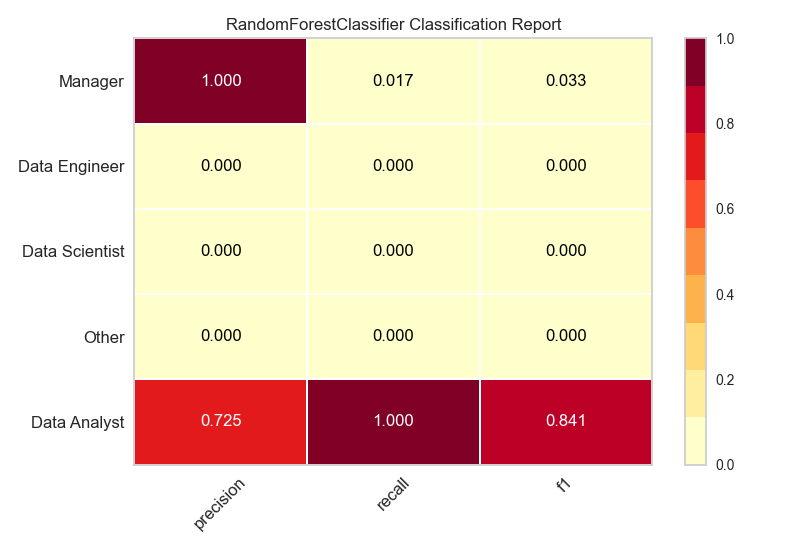

In [73]:
# Classification Report
"""Data Analyst      1128
Other              401
Data Scientist      14
Data Engineer       12
Manager              4"""

plt.figure()
visualizer = ClassificationReport(rfModel, classes=target_names)
visualizer.fit(X=x1, y=x2)    
visualizer.score(y1, y2)      

g = visualizer.poof()
g.get_figure().savefig("images/RFCReport.png")

This result is really connected with the number of items of each class. Data analyst is the most occurred so it has the best preciision, recall anf f1 results.

The next classifier model that I am going to try is a Neural Network. Let's see the results. I have tried to use different configurations but the one that has generated better results is the following one. For smaller datasets, like the one that I am using, the lbfgs is reccomended because can converge faster and perform better. Nevertheless, adam solver or stochastic gradient descent have obtained the same results.

In [68]:
# Neural Network
nnModel = MLPClassifier(solver='adam', alpha = 1e-5, hidden_layer_sizes = (500,), random_state = 10, max_iter = 10000, activation = 'logistic',
                                           momentum = 0.9)

nnModel.fit(X=x1, y=x2)
result = nnModel.predict(y[Features])

In [69]:
# Model Evaluation
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')

print("========== Neural Network Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)

========== Neural Network Results ==========
Accuracy    :  0.7222222222222222
Recall      :  0.7222222222222222
Precision   :  0.5216049382716049
F1 Score    :  0.7222222222222222


<IPython.core.display.Javascript object>


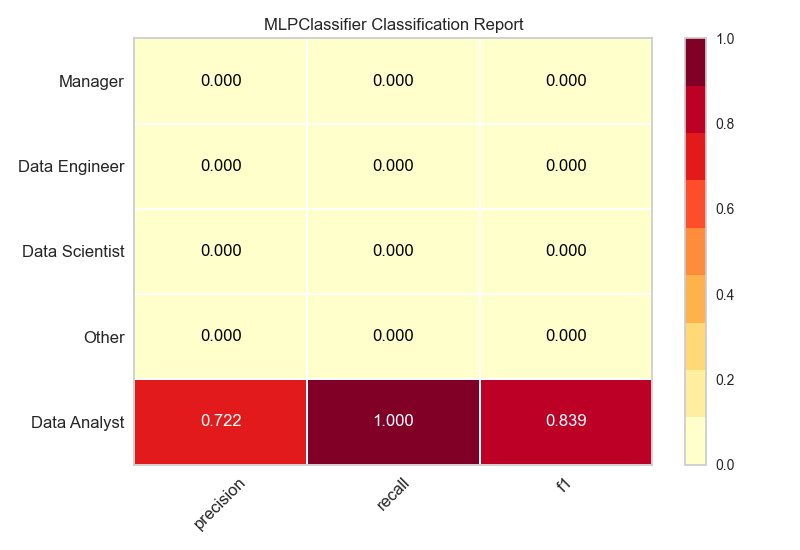

In [72]:
plt.figure()
visualizer = ClassificationReport(nnModel, classes=target_names)
visualizer.fit(X=x1, y=x2) 
visualizer.score(y1, y2)

g = visualizer.poof()
g.get_figure().savefig("images/NNCReport.png")

As you can see the Neural network has similar results in accuracy, recall and f1 score values but the precission has decreased. Let's see which classification model obtains the best results.

In [71]:
from lazypredict.Supervised import LazyClassifier

X_train, X_test, y_train, y_test = train_test_split(df.values, dataset['Job Title'].values,test_size=.3,random_state =123)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  4.95it/s]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.73               0.28    None      0.70   
XGBClassifier                      0.70               0.28    None      0.68   
LGBMClassifier                     0.71               0.28    None      0.68   
ExtraTreeClassifier                0.66               0.28    None      0.66   
ExtraTreesClassifier               0.72               0.27    None      0.69   
BaggingClassifier                  0.72               0.27    None      0.68   
DecisionTreeClassifier             0.64               0.27    None      0.64   
NearestCentroid                    0.35               0.25    None      0.44   
LabelPropagation                   0.66               0.24    None      0.66   
LabelSpreading                     0.66               0.24    None      0.66   
AdaBoostClassifier                 0.51               0.23    None      0.51   
BernoulliNB                        0.73               0.23    None      0.67   
KNeighborsClassifier               0.70               0.22    None      0.66   
QuadraticDiscriminantAnalysis      0.71               0.22    None      0.65   
LinearDiscriminantAnalysis         0.73               0.22    None      0.64   
LogisticRegression                 0.73               0.22    None      0.64   
GaussianNB                         0.68               0.21    None      0.64   
CalibratedClassifierCV             0.73               0.21    None      0.63   
RidgeClassifier                    0.73               0.21    None      0.63   
RidgeClassifierCV                  0.73               0.21    None      0.63   
LinearSVC                          0.73               0.21    None      0.63   
SVC                                0.73               0.21    None      0.63   
Perceptron                         0.61               0.20    None      0.60   
DummyClassifier                    0.72               0.20    None      0.60   
SGDClassifier                      0.69               0.20    None      0.61   
PassiveAggressiveClassifier        0.51               0.18    None      0.54   

                               Time Taken  
Model                                      
RandomForestClassifier               0.62  
XGBClassifier                        0.64  
LGBMClassifier                       1.00  
ExtraTreeClassifier                  0.03  
ExtraTreesClassifier                 0.61  
BaggingClassifier                    0.13  
DecisionTreeClassifier               0.03  
NearestCentroid                      0.02  
LabelPropagation                     0.16  
LabelSpreading                       0.16  
AdaBoostClassifier                   0.30  
BernoulliNB                          0.03  
KNeighborsClassifier                 0.10  
QuadraticDiscriminantAnalysis        0.02  
LinearDiscriminantAnalysis           0.04  
LogisticRegression                   0.10  
GaussianNB                           0.03  
CalibratedClassifierCV               1.08  
RidgeClassifier                      0.03  
RidgeClassifierCV                    0.04  
LinearSVC                            0.31  
SVC                                  0.19  
Perceptron                           0.04  
DummyClassifier                      0.02  
SGDClassifier                        0.04  
PassiveAggressiveClassifier          0.04

There are some models that obtain the best results in accuracy but the best one is Random Forest Classifier.  
I have concluded that the classification models generate some decent values but I tink that this is strictly related to the disbalanced number of items for each class that are in the dataset. This is easily seen in balanced accuracy values that are really low because some classes have 0 in accuracy what really contrasts with the 1.00 accurcay value in Data Analyst.

# 7.Future Work

The dataset could be processed without dropping all the NaN values and changing them by mean or using KNNImputer function. One thing that can also be done is use grid search to find the best hyperparameters for the models. Combining the two things maybe the results that will generate the models, mostly the predictor, will be much better